# Water Quality Parameters

This notebook aims at computing the descriptive statistics for the WQP maps, or any raster, by defining specific features from which these statistics are requested (located within the [in](./in) folder). In addition, the analysis of the WQP maps will consider de extraction of sampling data inside the pixels to review the estimates.

In [1]:
# Styling notebook

# System
import os
import sys

# Import scripts libraries for the project
sys.path.append('./src/python')

# Import the function to update the notebook style
from nbConfig import (css_styling)

css_styling()

In [2]:
from matplotlib import rcParams
font = {'family' : 'Georgia',
#         'weight' : 'bold',
        'size'   : 12}

## 0. Import Libraries

In [3]:
# Data
import numpy as np
import pandas as pd

# Spatial Data
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# Data visualization
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns
from rasterio.plot import show_hist
import ipywidgets as wg

# Import custom libraries
import wqpFunctions as wqp

Define the working directory for the WQP processing

In [4]:
# Current Working Directories
cwd = {
    'local': '.',
    'in': './in/data/wqp/',
    'out': './out/OutlierRejection',
    'vector': './vector',
}

Import the vector files for data extraction of the WQP maps

In [5]:
# Layer dataset
gdf_lakes = gpd.read_file(os.path.join(cwd['vector'],'simile_laghi','simile_laghi.shp'))
# Buoy position in the lake
gdf_buoy = gpd.read_file(os.path.join(cwd['vector'],'boa_sample_points','boa_sample_points.shp'))
# Random sampling points
gdf_sample = gpd.read_file(os.path.join(cwd['vector'],'random_points','random_points.shp'))

DriverError: ./vector/boa_sample_points/boa_sample_points.shp: No such file or directory

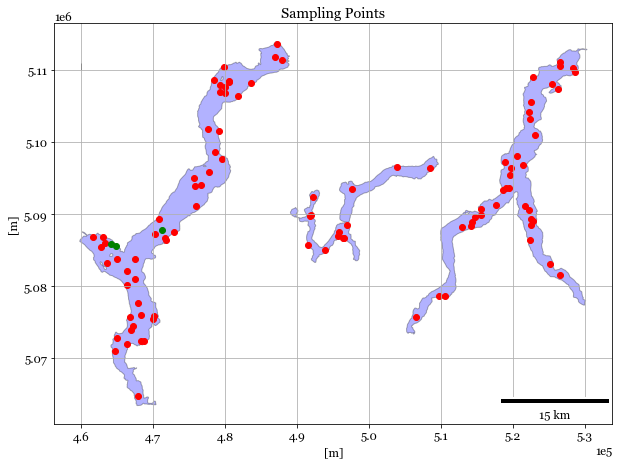

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
plt.rc('font', **font)
gdf_lakes.plot(ax = ax, color= 'blue', edgecolor='k', alpha = 0.3)
gdf_sample.plot(ax = ax, color='red')
gdf_buoy.plot(ax = ax, color='green')

scale = ScaleBar(
    dx=1,
    location='lower right',  # in relation to the whole plot
    label_loc='left', scale_loc='bottom',  # in relation to the line
)

ax.set_title('Sampling Points')
ax.tick_params(labelsize=12)
ax.set_xlabel('[m]')
ax.set_ylabel('[m]')
ax.add_artist(scale)
ax.ticklabel_format(axis='both', style='sci', scilimits=(5,4))

ax.arrow(4.6e5,5.11e6,0,1000)
ax.grid()

Review the contents of the folder

### Select WQP and Outlier Rejection Method

In [44]:
SENSOR_LIST = ['S3','L8','EUMETSAT']
sensor = wg.Select(
    options = SENSOR_LIST,
    value = SENSOR_LIST[1],
    description = 'Select the sensor:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='20%', height='100px'),
)

In [45]:
WQP_LIST = ['chl','tsm','lswt']
wqpMaps = wg.Select(
    options = WQP_LIST,
    value = WQP_LIST[2],
    description = 'Select the wqp:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='15%', height='100px'),
)

In [46]:
OUTLIERS_METHOD_LIST = ['IQR','2Sigma','3Sigma']
outlierMethods = wg.Select(
    options = OUTLIERS_METHOD_LIST,
    value = OUTLIERS_METHOD_LIST[0],
    description = 'Select the outlier method:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='30%', height='100px'),
)

In [47]:
REF_PROD_LIST = ['wqp','wqp_cloud_mask','wqp_no_clip','wqp_no_mask','wqp_high_clouds','wqp_mid_high_clouds', 'full_outlierRejection']#last 2 L8
refProducts = wg.Select(
    options = REF_PROD_LIST,
    value = REF_PROD_LIST[4],
    description = 'Select ref product:',
    disabled = False,
    style = {
        'description_width': 'auto'
    },
    layout = wg.Layout(width='35%', height='100px'),
)

In [48]:
wg.HBox([sensor,wqpMaps, outlierMethods,refProducts])

## 1. WQP Descriptive Statistics and Sampling Points

In [63]:
# in_path = os.path.join('.\\in\\data\\wqp\\S3\\wqp\\tsm\\cropped')
in_path = os.path.join('./extract_lswt')
# in_path = os.path.join('./in/data/wqp/L8/wqp_high_clouds/lswt/cropped')
# in_path = os.path.join('./out/OutlierRejection/wqp/3Sigma/lswt')
# in_path = os.path.join(cwd['out'],'wqp',outlierMethods.value, wqpMaps.value)
# in_path = os.path.join('./out/Coregistration/wqp/S3/full/chl')
# in_path = os.path.join('./out/Coregistration/wqp/S3/full_outlierRejection/3Sigma/tsm')
# out_path = os.path.join('.\\in\\data\\wqp\\S3\\wqp\\tsm\\cropped')
# out_path = os.path.join(cwd['out'],'wqp',outlierMethods.value, wqpMaps.value)
# out_path = os.path.join('./out/OutlierRejection/wqp/3Sigma/lswt')
# out_path = os.path.join('./out/Coregistration/wqp/S3/full_outlierRejection/3Sigma/tsm')
out_path = os.path.join('./extract_lswt')
for root, dirs, files in os.walk(in_path):
    for file in files:
        try:
            # Verify check if the stats and products have been computed
            if ((file.endswith('.tif')) & (dirs != ['outliers'])):
                if (file.split('.') not in os.listdir(in_path)):
                    f = os.path.join(in_path,file)
                    
                    # Read file
                    src = wqp.wqp(f)
                    src.readWQP()
                    print(src.name)
#                     src.name
                    # Export dataset (check no data values)
#                     t = src.image.read(1)
#                     t = np.nan_to_num(t)
#                     t[t<=0] = np.nan
#                     src.writeWQP(cwd['out'],t)

                    # Extract information from sampling points
        #             src.extractSamplePoints(gdf_sample)
        #             src.extractSamplePoints(gdf_buoy)
        #             src.samplePoint.to_csv(os.path.join(cwd['out'],'sample_points',src.name+'.csv'))

                    # Compute statistics for the lakes polygons
                    src.computeStatistics(gdf_lakes, 'Nome',"count min mean max median std  percentile_25 percentile_50 percentile_75",-9999)

                    # Format output
                    df = wqp.wqp.exportWQPFormatStats(src)

                    # Export the statistics result to a file (append data if existing)
                    out_file = os.path.join(out_path,f'lakesStats_{wqpMaps.value}.csv')
#                     print(out_path,f'lakesStats_{wqpMaps.value}.csv')
                    if os.path.exists(out_file):
                        df.to_csv(os.path.join(out_path,f'lakesStats_{wqpMaps.value}.csv'),mode='a', header=False)
                    else:
                        df.to_csv(os.path.join(out_path,f'lakesStats_{wqpMaps.value}.csv')) 
        except:
            print(err)

NameError: name 'err' is not defined

## 2. Outlier Rejection Methods

Create the outliers "free" maps based on the selected wqpMaps and otulierMethods selected above

In [22]:
in_path = os.path.join(cwd['in'],sensor.value,refProducts.value,wqpMaps.value)
out_path = os.path.join(cwd['out'],'wqp',outlierMethods.value, wqpMaps.value)
shared_maps = list(set(os.listdir(in_path)).intersection(os.listdir(out_path)))
missing_maps = list(set(os.listdir(in_path)) ^ set(os.listdir(out_path)))
for root, dirs, files in os.walk(in_path):
    for file in missing_maps:
        if ((file.endswith('.tif')) & (['cropped']==dirs)):
            print(in_path,file)
            f = os.path.join(in_path,file)
            try:
                # Read file
                src = wqp.wqp(f)
                src.readWQP()
                # Crop the lakes by the lakes 
                src.cropRasterByFeatures(os.path.join(cwd['vector'],'simile_laghi','simile_laghi.shp'),'Nome')

                # Compute statistics for the lakes polygons
                src.computeStatistics(gdf_lakes, 'Nome',"count min mean max median std percentile_25 percentile_50 percentile_75",0)
                print(src.name)
                # Apply the outlier rejection method
                src.outlierRejection(method=outlierMethods.value, minLower=0, maxUpper = 30)    

                # Export the outlier rejection products
                src.mergeRasterCollectionsExport(src.raster_collection, os.path.join(out_path, src.name + '.tif'))
                src.mergeRasterCollectionsExport(src.outliers_collection, os.path.join(out_path,'outliers', src.name + '.tif'))

                # Export outliers data
                df = wqp.wqp.exportWQPFormatStatsOutliers(src)

                # Export the statistics result to a file (append data if existing)
                out_file = os.path.join(out_path,'outliers',f'lakesStats_{outlierMethods.value}_{wqpMaps.value}.csv')
                if os.path.exists(out_file):
                    df.to_csv(os.path.join(out_path,'outliers',f'lakesStats_{outlierMethods.value}_{wqpMaps.value}.csv'),mode='a', header=False)
                else:
                    df.to_csv(os.path.join(out_path,'outliers',f'lakesStats_{outlierMethods.value}_{wqpMaps.value}.csv')) 
            except:
                # Open a file with access mode 'a'
                file_object = open(os.path.join(out_path,f'error_images_{sensor.value}.txt'), 'a')
                # Append 'hello' at the end of file
                file_object.write(src.name)
                file_object.write("\n")
                # Close the file
                file_object.close()

./in/data/wqp/S3\wqp\chl S3B_CHL_IT_20190927T092131_L1.tif
S3B_CHL_IT_20190927T092131_L1
Missing Stats for Lake Maggiore
Missing Stats for Lake Como
Missing Stats for Lake Lugano
./in/data/wqp/S3\wqp\chl S3B_CHL_IT_20201104T094756_L1.tif
S3B_CHL_IT_20201104T094756_L1
Missing Stats for Lake Maggiore
Missing Stats for Lake Como
Missing Stats for Lake Lugano
./in/data/wqp/S3\wqp\chl S3B_CHL_IT_20210521T091418_L1.tif
S3B_CHL_IT_20210521T091418_L1
Missing Stats for Lake Maggiore
Missing Stats for Lake Como
Missing Stats for Lake Lugano
./in/data/wqp/S3\wqp\chl S3B_CHL_IT_20220125T095912_L1.tif
S3B_CHL_IT_20220125T095912_L1
Missing Stats for Lake Maggiore
Missing Stats for Lake Como
Missing Stats for Lake Lugano
./in/data/wqp/S3\wqp\chl S3A_CHL_IT_20200810T091617_L1.tif
S3A_CHL_IT_20200810T091617_L1
Missing Stats for Lake Maggiore
Missing Stats for Lake Como
Missing Stats for Lake Lugano
./in/data/wqp/S3\wqp\chl S3B_CHL_IT_20210616T094035_L1.tif
S3B_CHL_IT_20210616T094035_L1
Missing Stats fo

In [24]:
# TODO: apply the outlier rejection method to the missing datasets

# OUTLIER REJECTION FOR THE WQP COREGISTRERED MAPS

in_path = os.path.join('./out/Coregistration/wqp',sensor.value,'full',wqpMaps.value)
out_path = os.path.join('./out/Coregistration/wqp',sensor.value,refProducts.value,outlierMethods.value,wqpMaps.value)
print(in_path)
print(out_path)
for root, dirs, files in os.walk(in_path):
    for file in files:
        print(dirs)
        if ((file.endswith('.tif')) & ([]==dirs)):
            print(in_path,file)
            f = os.path.join(in_path,file)
            try:
                # Read file
                src = wqp.wqp(f)
                src.readWQP()
                # Crop the lakes by the lakes 
                src.cropRasterByFeatures(os.path.join(cwd['vector'],'simile_laghi','simile_laghi.shp'),'Nome')

                # Compute statistics for the lakes polygons
                src.computeStatistics(gdf_lakes, 'Nome',"count min mean max median std percentile_25 percentile_50 percentile_75",0)
                print(src.name)
                # Apply the outlier rejection method
                src.outlierRejection(method=outlierMethods.value, minLower=0, maxUpper = 30)    

                # Export the outlier rejection products
                src.mergeRasterCollectionsExport(src.raster_collection, os.path.join(out_path, src.name + '.tif'))
                src.mergeRasterCollectionsExport(src.outliers_collection, os.path.join(out_path,'outliers', src.name + '.tif'))

                # Export outliers data
                df = wqp.wqp.exportWQPFormatStatsOutliers(src)

                # Export the statistics result to a file (append data if existing)
                out_file = os.path.join(out_path,'outliers',f'lakesStats_{outlierMethods.value}_{wqpMaps.value}.csv')
                if os.path.exists(out_file):
                    df.to_csv(os.path.join(out_path,'outliers',f'lakesStats_{outlierMethods.value}_{wqpMaps.value}.csv'),mode='a', header=False)
                else:
                    df.to_csv(os.path.join(out_path,'outliers',f'lakesStats_{outlierMethods.value}_{wqpMaps.value}.csv')) 
            except:
                # Open a file with access mode 'a'
                file_object = open(os.path.join(out_path,f'error_images_{sensor.value}.txt'), 'a')
                # Append 'hello' at the end of file
                file_object.write(src.name)
                file_object.write("\n")
                # Close the file
                file_object.close()

./out/Coregistration/wqp\S3\full\tsm
./out/Coregistration/wqp\S3\full_outlierRejection\3Sigma\tsm
[]
./out/Coregistration/wqp\S3\full\tsm S3A_TSM_IT_20190101T093449_L1.tif
S3A_TSM_IT_20190101T093449_L1
Missing Stats for Lake Como
[]
./out/Coregistration/wqp\S3\full\tsm S3A_TSM_IT_20190107T101943_L1.tif
S3A_TSM_IT_20190107T101943_L1
[]
./out/Coregistration/wqp\S3\full\tsm S3A_TSM_IT_20190108T095332_L1.tif
S3A_TSM_IT_20190108T095332_L1
Missing Stats for Lake Como
Missing Stats for Lake Lugano
[]
./out/Coregistration/wqp\S3\full\tsm S3A_TSM_IT_20190109T092721_L1.tif
S3A_TSM_IT_20190109T092721_L1
[]
./out/Coregistration/wqp\S3\full\tsm S3A_TSM_IT_20190112T094948_L1.tif
S3A_TSM_IT_20190112T094948_L1
Missing Stats for Lake Como
Missing Stats for Lake Lugano
[]
./out/Coregistration/wqp\S3\full\tsm S3A_TSM_IT_20190113T092337_L1.tif
S3A_TSM_IT_20190113T092337_L1
[]
./out/Coregistration/wqp\S3\full\tsm S3A_TSM_IT_20190115T101215_L1.tif
S3A_TSM_IT_20190115T101215_L1
[]
./out/Coregistration/wqp\S3